# Simple Transformer Implementation in PyTorch

Architecture of the transformer model:
* Input Embedding with Positional Encoding
* Multi-Head Attention
* Multi-Layer Perceptron (MLP)
* Transformer Block
* Output Layer



## Import required libraries


In [1]:
import urllib.request
import os
from dataclasses import dataclass
from typing import Any, Tuple, List

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import math
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot as plt

import numpy as np

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
CUDA available: True


## Dataset Preparation

### Download the tiny Shakespeare dataset

In [3]:
URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
FILE_NAME = "input.txt"
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

FULL_PATH = os.path.join(DATA_DIR, FILE_NAME)

# Download the dataset if it doesn't exist
if not os.path.exists(FULL_PATH):
    urllib.request.urlretrieve(URL, FULL_PATH)

print("Dataset downloaded to:", FULL_PATH)

with open(FULL_PATH, 'r', encoding='utf-8') as f:
    text = f.read()
    print("Dataset length (characters):", len(text))

Dataset downloaded to: data/input.txt
Dataset length (characters): 1115394


### Tokenization

In [4]:
VOCAB_SIZE = int(math.sqrt(len(text)))
TOKENIZER_SAVE_PATH = os.path.join(DATA_DIR, "bpe_tokenizer.json")

def train_bpe_tokenizer(text: str, vocab_size:int, save_path: str) -> Tokenizer:
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()

    trainer = BpeTrainer(
        vocab_size=vocab_size,
        special_tokens = ["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
        show_progress=True
    )

    tokenizer.train_from_iterator([text], trainer=trainer)
    tokenizer.save(save_path)

    print("Tokenizer trained and saved to:", save_path)
    return tokenizer

In [5]:
tokenizer = train_bpe_tokenizer(text, VOCAB_SIZE, TOKENIZER_SAVE_PATH)



Tokenizer trained and saved to: data/bpe_tokenizer.json


### Create PyTorch Dataset and DataLoader

In [6]:
class CustomDataset(Dataset):
    def __init__(self, text: str, tokenizer: Tokenizer, seq_length: int = 128, train: bool = True, train_split: float = 0.8):
        self.text = text
        self.tokenizer = tokenizer
        self.seq_length = seq_length
        self.train = train
        self.train_split = train_split

        # Encode the entire text
        encoded_text = self.tokenizer.encode(self.text)
        self.tokens = torch.tensor(encoded_text.ids, dtype=torch.long)

        # Split into train and validation sets
        split_idx = int(len(self.tokens) * self.train_split)
        if self.train:
            self.tokens = self.tokens[:split_idx]
        else:
            self.tokens = self.tokens[split_idx:]

        print("Dataset initialized. Total tokens:", len(self.tokens))

    def __len__(self):
        return max(0, len(self.tokens) - self.seq_length)

    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.seq_length], self.tokens[idx+1:idx+self.seq_length+1]


In [7]:
# Create train and validation datasets
SEQ_LENGTH = 128
BATCH_SIZE = 32

train_dataset = CustomDataset(text, tokenizer, seq_length=SEQ_LENGTH, train=True)
val_dataset = CustomDataset(text, tokenizer, seq_length=SEQ_LENGTH, train=False)

# Create DataLoaders
# For training, we shuffle the data to ensure the model sees different sequences each epoch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Note: For validation, we typically don't shuffle the data because we want to evaluate on the same sequence of data each epoch
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Dataset initialized. Total tokens: 303268
Dataset initialized. Total tokens: 75817


## Transformer Model Implementation

### Transformer Input Embedding with Sinusoidal Positional Encoding

In [8]:
class TransformerInputEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, max_seq_length: int, *args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        pe = self._create_positional_encoding(max_seq_length, embed_dim)
        self.register_buffer('positional_encoding', pe)


    def _create_positional_encoding(self, max_seq_length: int, embed_dim: int) -> torch.Tensor:
        pe = torch.zeros(max_seq_length, embed_dim) # Shape (max_seq_length, embed_dim)
        position = torch.arange(0, max_seq_length).unsqueeze(1).float() # Shape (max_seq_length, 1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)) # Shape (embed_dim/2,)
        # For even elements where we get shape (max_seq_length, ceil(embed_dim/2)) after multiplication
        pe[:,0::2] = torch.sin(position * div_term)
        # For odd elements where we get shape (max_seq_length, ceil(embed_dim/2)) after multiplication
        pe[:,1::2] = torch.cos(position * div_term[:pe[:,1::2].shape[1]])

        return pe.unsqueeze(0)  # Shape: (1, max_seq_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len), dtype long
        seq_length = x.size(1)
        if seq_length > self.positional_encoding.size(1):
            raise ValueError(f"seq_length={seq_length} exceeds max_seq_length={self.positional_encoding.size(1)}")

        token_embeds = self.token_embedding(x)  # (batch, seq_len, embed_dim)
        pos_embeds = self.positional_encoding[:, :seq_length, :]  # (1, seq_len, embed_dim)
        return token_embeds + pos_embeds

### Multi-Head Attention

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1, *args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)

        # embed_dim must be divisible by num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                x: torch.Tensor,
                attn_mask: torch.Tensor | None = None,
                key_padding_mask: torch.Tensor | None = None,
                is_causal: bool = False, return_attn =False
                ) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (batch, seq_len, embed_dim)
            attn_mask: optional mask broadcastable to (batch, num_heads, seq_len, seq_len)
                - bool mask: True means "block this attention"
                - or float mask: additive (e.g., 0 for allow, -inf for block)
            key_padding_mask: (batch, seq_len) bool, True for PAD positions to ignore
            is_causal: if True, prevents attending to future tokens (GPT-style)
            return_attn: if True, also returns attention weights (batch, num_heads, seq_len, seq_len)

        Returns:
            out: (batch, seq_len, embed_dim)
            (optional) attn_weights
        """

        batch_size, seq_len, _ = x.size()

        # Linear projections to get Q, K, V: (batch, seq_len, embed_dim)
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Reshape for multi-head: (batch, num_heads, seq_len, head_dim)
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention scores: (batch, num_heads, seq_len, seq_len)
        scale = 1.0 / math.sqrt(self.head_dim)
        attn_scores = (q @ k.transpose(-2, -1)) * scale

        # value used as a negative infinity for masking
        neg_inf = torch.finfo(attn_scores.dtype).min

        # Causal mask (prevent attending to future tokens)
        if is_causal:
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool), diagonal=1) # (seq_len, seq_len)
            attn_scores = attn_scores.masked_fill(causal_mask, neg_inf)

        # Attention mask (e.g., for padding)
        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_scores = attn_scores.masked_fill(attn_mask, neg_inf)
            else:
                attn_scores = attn_scores + attn_mask

        # Key padding mask (mask out PAD tokens)
        if key_padding_mask is not None:
            # key padding mask: (batch, seq_len) -> (batch, 1, 1, seq_len) for broadcasting
            key_padding_mask = key_padding_mask[:, None, None, :]
            attn_scores = attn_scores.masked_fill(key_padding_mask, neg_inf)

        # Attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)
        attn_weights = self.dropout(attn_weights)

        # Weighted sum of values
        context = attn_weights @ v  # (batch, num_heads, seq_len, head_dim)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)  # (batch, seq_len, embed_dim

        # Final linear projection
        out = self.out_proj(context)  # (batch, seq_len, embed_dim)
        out = self.dropout(out)

        if return_attn:
            return out, attn_weights

        return out



### Multi-Layer Perceptron (MLP)

In [10]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int, hidden_dim: int, dropout: float = 0.1, activation: str = "gelu",*args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)

        act = activation.lower()

        switcher = {
            "gelu": nn.GELU(),
            "relu": nn.ReLU(),
            "silu": nn.SiLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(),
        }

        if act not in switcher:
            raise ValueError(f"Unsupported activation: {activation}")

        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = switcher[act]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, embed_dim)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x) # (batch, seq_len, embed_dim)
        x = self.dropout(x)

        return x

### Transformer block implementation

#### Global configuration for the transformer model

In [11]:
@dataclass
class ModelConfig:
    vocab_size: int = VOCAB_SIZE
    max_seq_length: int = SEQ_LENGTH
    embed_dim: int = 256
    num_heads: int = 8
    num_layers: int = 6
    dropout: float = 0.1
    activation: str = "gelu"

    # MLP hidden dimension is typically 4x the embed_dim in transformer architectures
    mlp_hidden_dim: int = 1024

    # Special token IDs (these should match the tokenizer's special tokens)
    pad_token_id: int = 1
    bos_token_id: int = 2
    eos_token_id: int = 3



In [12]:
CFG = ModelConfig()

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, mlp_hidden_dim: int, dropout: float, activation: str, *args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)
        self.attention = MultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            embed_dim = embed_dim,
            hidden_dim = mlp_hidden_dim,
            dropout = dropout,
            activation = activation
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor | None = None, key_padding_mask: torch.Tensor | None = None, is_causal: bool = True) -> torch.Tensor:
        # x: (batch, seq_len, embed_dim)
        # Residual connection and layer normalization
        x = x + self.attention(self.norm1(x), attn_mask=attn_mask, key_padding_mask=key_padding_mask, is_causal=is_causal)

        # Residual connection and layer normalization
        x = x +  self.mlp(self.norm2(x))


        return x

### Output layer and Transformer LM assembly

In [20]:
class TransformerLM(nn.Module):
    def __init__(self, cfg: ModelConfig, *args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)
        self.cfg = cfg
        self.input_embedding = TransformerInputEmbedding(
            vocab_size=cfg.vocab_size,
            embed_dim=cfg.embed_dim,
            max_seq_length=cfg.max_seq_length,
        )
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=cfg.embed_dim,
                num_heads=cfg.num_heads,
                mlp_hidden_dim=cfg.mlp_hidden_dim,
                dropout=cfg.dropout,
                activation=cfg.activation
            ) for _ in range(cfg.num_layers)
        ])
        self.output_layer = nn.Linear(cfg.embed_dim, cfg.vocab_size)

        self.ln_f = nn.LayerNorm(cfg.embed_dim)
        self.lm_head = nn.Linear(cfg.embed_dim, cfg.vocab_size, bias=False)

        # Tie weights between input embedding and output layer
        self.output_layer.weight = self.input_embedding.token_embedding.weight

    def forward(self,
                x: torch.Tensor,
                is_causal: bool = True,
                targets: torch.Tensor | None = None,
                casual_mask: torch.Tensor | None = None,
                key_padding_mask: torch.Tensor | None = None) -> tuple[torch.Tensor, torch.Tensor | None]:
        # x: (batch, seq_len)
        # targets: (batch, seq_len) or None

        # if user didn't provide a padding mask, create one from pad_token_id
        if key_padding_mask is None and self.cfg.pad_token_id is not None:
            key_padding_mask = (x == self.cfg.pad_token_id)

        x = self.input_embedding(x)  # (batch, seq_len, embed_dim)

        for block in self.transformer_blocks:
            x = block(x, attn_mask=casual_mask, key_padding_mask=key_padding_mask, is_causal=is_causal)

        x = self.ln_f(x)  # (batch, seq_len, embed_dim)
        logits = self.lm_head(x)  # (batch, seq_len, vocab_size

        loss = None
        if targets is not None:
            # Flatten the logits and targets for cross-entropy loss
            B, T, V = logits.size()
            logits_2d = logits.view(B * T, V)
            targets_1d = targets.view(B * T)

            # Ignore PAD in loss calculation
            loss = F.cross_entropy(logits_2d, targets_1d, ignore_index=self.cfg.pad_token_id)

        return logits, loss

### Train and evaluate the model

#### Training loop with checkpointing and early stopping

In [15]:
from pathlib import Path
from typing import Optional


def save_checkpoint(
    checkpoint_path: str,
    epoch: int,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    val_loss: float,
):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_loss": float(val_loss),
    }
    torch.save(checkpoint, checkpoint_path)


def load_checkpoint(model: nn.Module, checkpoint_path: str, device: str = "cpu") -> nn.Module:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(
        f"Loaded checkpoint from epoch {checkpoint['epoch']} "
        f"with val_loss={checkpoint['val_loss']:.4f}"
    )
    return model


def _unpack_batch(batch: Any) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:

    key_padding_mask = None

    if isinstance(batch, (list, tuple)):
        if len(batch) == 2:
            x, y = batch
        elif len(batch) == 3:
            x, y, key_padding_mask = batch
        else:
            raise ValueError("Batch tuple/list must be (x,y) or (x,y,mask).")
        return x, y, key_padding_mask

    if isinstance(batch, dict):
        # common naming variations
        x = batch.get("input_ids", batch.get("x"))
        y = batch.get("labels", batch.get("y"))
        key_padding_mask = batch.get("key_padding_mask", None)

        if x is None or y is None:
            raise ValueError("Batch dict must contain input_ids/x and labels/y.")
        return x, y, key_padding_mask

    raise ValueError("Unsupported batch format.")


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 1e-4,
    checkpoint_dir: str = "checkpoints",
    patience: int = 3,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    grad_clip: Optional[float] = 1.0,
) -> Tuple[nn.Module, List[float], List[float]]:

    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_dir = str(Path(checkpoint_dir))

    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    bad_epochs = 0

    train_losses: List[float] = []
    val_losses: List[float] = []

    best_path = os.path.join(checkpoint_dir, "best_model.pt")
    last_path = os.path.join(checkpoint_dir, "last_model.pt")

    for epoch in range(1, num_epochs + 1):
        # Train the model for one epoch
        model.train()
        running_train_loss = 0.0
        n_train_batches = 0

        for batch in train_loader:
            x, y, key_padding_mask = _unpack_batch(batch)

            x = x.to(device)
            y = y.to(device)
            if key_padding_mask is not None:
                key_padding_mask = key_padding_mask.to(device)

            optimizer.zero_grad(set_to_none=True)

            _, loss = model(x, targets=y, key_padding_mask=key_padding_mask)
            if loss is None:
                raise RuntimeError("Model returned loss=None. Make sure you pass targets correctly.")

            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            running_train_loss += loss.item()
            n_train_batches += 1

        avg_train_loss = running_train_loss / max(1, n_train_batches)
        train_losses.append(avg_train_loss)

        # Validate the model
        model.eval()
        running_val_loss = 0.0
        n_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                x, y, key_padding_mask = _unpack_batch(batch)

                x = x.to(device)
                y = y.to(device)
                if key_padding_mask is not None:
                    key_padding_mask = key_padding_mask.to(device)

                _, loss = model(x, targets=y, key_padding_mask=key_padding_mask)
                if loss is None:
                    raise RuntimeError("Model returned loss=None during validation.")

                running_val_loss += loss.item()
                n_val_batches += 1

        avg_val_loss = running_val_loss / max(1, n_val_batches)
        val_losses.append(avg_val_loss)

        # Save "last" checkpoint
        save_checkpoint(
            checkpoint_path=last_path,
            epoch=epoch,
            model=model,
            optimizer=optimizer,
            val_loss=avg_val_loss,
        )

        # Check for improvement
        improved = avg_val_loss < best_val_loss
        if improved:
            best_val_loss = avg_val_loss
            bad_epochs = 0
            save_checkpoint(
                checkpoint_path=best_path,
                epoch=epoch,
                model=model,
                optimizer=optimizer,
                val_loss=avg_val_loss,
            )
        else:
            bad_epochs += 1

        print(
            f"Epoch {epoch:03d}/{num_epochs} | "
            f"train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f} | "
            f"{'BEST' if improved else f'patience {bad_epochs}/{patience}'}"
        )

        # Early stopping
        if bad_epochs >= patience:
            print(f"Early stopping: no val improvement for {patience} epochs.")
            break

    # Load best weights back into the model before returning
    model = load_checkpoint(model, best_path, device=device)
    return model, train_losses, val_losses

### Train the model

In [16]:
CHECKPOINT_DIR = "checkpoints"
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pt")

if os.path.exists(BEST_MODEL_PATH):
    print(f"Found existing checkpoint at {BEST_MODEL_PATH}. Loading model from checkpoint...")
    model = load_checkpoint(TransformerLM(CFG), BEST_MODEL_PATH, device="cuda" if torch.cuda.is_available() else "cpu")
else:
    model = TransformerLM(CFG)
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=2,
    learning_rate=3e-4,
    checkpoint_dir=CHECKPOINT_DIR,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Epoch 001/2 | train_loss=2.1061 | val_loss=7.6616 | BEST
Epoch 002/2 | train_loss=0.6996 | val_loss=9.0745 | patience 1/5
Loaded checkpoint from epoch 1 with val_loss=7.6616


#### Plot training and validation loss curves

In [17]:
def plot_losses_detailed(train_losses: List[float], val_losses: List[float],
                        smoothing_window: int = 5, save_path: str = None):
    """
    Plot losses with optional smoothing for clearer trends.

    Args:
        train_losses: Training losses per epoch
        val_losses: Validation losses per epoch
        smoothing_window: Window size for moving average smoothing
        save_path: Path to save the figure
    """
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Raw losses
    ax1.plot(epochs, train_losses, 'b-', alpha=0.6, label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', alpha=0.6, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Raw Losses')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Smoothed losses
    if len(train_losses) > smoothing_window:
        train_smooth = uniform_filter1d(train_losses, size=smoothing_window)
        val_smooth = uniform_filter1d(val_losses, size=smoothing_window)

        ax2.plot(epochs, train_smooth, 'b-', linewidth=2, label='Train Loss (smoothed)')
        ax2.plot(epochs, val_smooth, 'r-', linewidth=2, label='Val Loss (smoothed)')
    else:
        ax2.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss')
        ax2.plot(epochs, val_losses, 'r-', linewidth=2, label='Val Loss')

    best_epoch = val_losses.index(min(val_losses)) + 1
    ax2.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'Smoothed Losses (window={smoothing_window})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    print(f"\nBest validation loss: {min(val_losses):.4f} at epoch {best_epoch}")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"Final val loss: {val_losses[-1]:.4f}")

#### Iterative generation function

In [18]:
def sample_next_token(logits: torch.Tensor, temperature: float = 1.0, top_k: int | None = 50) -> int:

    if temperature <= 0:
        # Greedy
        return int(torch.argmax(logits).item())

    logits = logits / temperature

    if top_k is not None and top_k > 0:
        topk_vals, topk_idx = torch.topk(logits, k=min(top_k, logits.size(-1)))
        probs = torch.softmax(topk_vals, dim=-1)
        next_idx_in_topk = torch.multinomial(probs, num_samples=1).item()

        return int(topk_idx[next_idx_in_topk].item())

    probs = torch.softmax(logits, dim=-1)
    return int(torch.multinomial(probs, num_samples=1).item())


@torch.no_grad()
def generate_text(
    model,
    tokenizer,
    prompt: str,
    max_new_tokens: int = 50,
    temperature: float = 1.0,
    top_k: int | None = 50,
    add_bos: bool = False,
):
    device = next(model.parameters()).device

    # Encode prompt -> token ids
    ids = tokenizer.encode(prompt).ids

    if add_bos and hasattr(model, "cfg") and model.cfg.bos_token_id is not None:
        ids = [model.cfg.bos_token_id] + ids

    # Keep everything in a tensor: (1, T)
    x = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        # If context is longer than model max, crop from the left
        if x.size(1) > model.cfg.max_seq_length:
            x = x[:, -model.cfg.max_seq_length :]

        logits, _ = model(x)              # logits: (1, T, vocab)
        last_logits = logits[0, -1, :]    # (vocab_size,)

        next_id = sample_next_token(last_logits, temperature=temperature, top_k=top_k)

        # Append next token
        next_token = torch.tensor([[next_id]], dtype=torch.long, device=device)
        x = torch.cat([x, next_token], dim=1)

        # Stop on EOS if you use it
        if hasattr(model, "cfg") and model.cfg.eos_token_id is not None:
            if next_id == model.cfg.eos_token_id:
                break

    # Decode full sequence
    out_ids = x[0].tolist()
    return tokenizer.decode(out_ids)

#### Generate text with the trained model

In [21]:
# Load best model later
best_model = TransformerLM(CFG)
best_model = load_checkpoint(best_model, "checkpoints/best_model.pt", device="cuda")

prompt = "To be, or not to be, that is the question:"
out = generate_text(
    best_model,
    tokenizer,
    prompt,
    max_new_tokens=40,
    temperature=0.9,
    top_k=50,
)

print(out)

Loaded checkpoint from epoch 1 with val_loss=7.6616
To be , or not to be , that is the que st ion : The vi ol ate ! LEONTES : H a them out of U nd er a st it , and ' s ink on earth , P o or ha ps , ' We were well know how to give


Plot saved to loss_curves.png


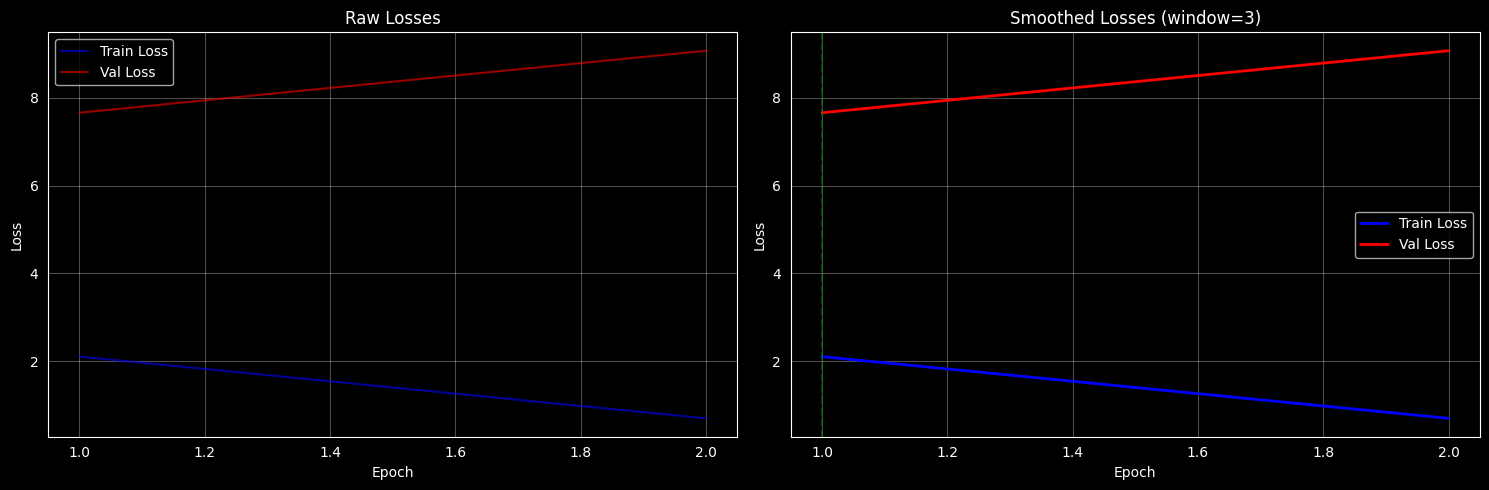


Best validation loss: 7.6616 at epoch 1
Final train loss: 0.6996
Final val loss: 9.0745


In [22]:
plot_losses_detailed(train_losses=train_losses, val_losses=val_losses, smoothing_window=3, save_path="loss_curves.png")